# 개발 환경

## Device Check

In [1]:
# Software & Hardware 개발 환경 상태 표시
from fastai.test_utils import show_install

show_install()



```text
=== Software === 
python       : 3.8.16
fastai       : 2.7.11
fastcore     : 1.5.29
fastprogress : 1.0.3
torch        : 1.13.1
torch cuda   : None / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : macOS-13.3.1-arm64-arm-64bit
conda env    : dacon
python       : /opt/homebrew/Caskroom/miniforge/base/envs/dacon/bin/python
sys.path     : /Users/mac/Git/DACON_AI_competition_for_predicting_Lymph_node_metastasis_of_breast_cancer/code
/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python38.zip
/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8
/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8/lib-dynload

/opt/homebrew/Caskroom/miniforge/base/envs/dacon/lib/python3.8/site-packages
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.



## cuda 인 경우 확인사항
- pytorch GPU device 
    - torch.cuda.is_available() : True
    - torch.cuda.current_device() : 0
    - torch.cuda.get_device_name() : GPU 이름 출력
    - torch.cuda.device(0) : cuda device 객체
- tensorflow GPU device 
    - from tensorflow.python.client import device_lib
    - print(device_lib.list_local_devices())*** 
    - gpu device type : "GPU" 확인
- cuda 환경에서의 requirements 출력하는 법 (개발 환경 정보)
    - from fastai.test_utils import show_install
    - show_install()

In [2]:
# 엔비디아 그래픽 드라이버, cuda 확인
#!nvidia-smi

In [3]:
# pytorch 에서 gpu cuda 설정 확인
import torch

if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name())
    print(torch.cuda.device(0))
else:
    print("This device is not cuda available")

This device is not cuda available


## [중요] device 설정 (CUDA OR MPS)
- device 상황에 따른 하드웨어 설정 후
- 각기 다른 utils.py 스크립트 임포트
- 이유 : cuda 인 경우는 텐서 연산을 cuda device에서, mac mps인 경우는 float32 타입으로 mps device에서 연산하기 때문

In [4]:
# device 상황에 따른 하드웨어 설정
if torch.cuda.is_available():  # CUDA ON NVIDIA GPU
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # MPS ON APPLE M1 MAC
    device = torch.device("mps:0")
else:
    device = torch.device("cpu")
print(f"This device type is {device.type}")

This device type is mps


## ultils.py & mil_net.py 로드

In [5]:
if device.type == "cuda":  # cuda
    from models.mil_net_cuda import MILNetWithClinicalData
    from utils.utils_cuda import *

    print(f"utils & mil_net are loaded for this device: {device}")
if device.type == "mps":  # mac
    from models.mil_net_mac import MILNetWithClinicalData
    from utils.utils_mac import *

    print(f"utils & mil_net are loaded for this device: {device}")

utils & mil_net are loaded for this device: mps:0


# Import

In [6]:
import random
import pandas as pd
import numpy as np
import os
import json
import random
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # 컨볼루션, 리니어, 액티베이션 펑션등을 미리 만들어놓은 라이브러리
# 모델 튜닝시 사용  # DataLoader : 데이터를 우리가 배치사이즈로 이용할 수 있게 형태를 바꿔주는 라이브러리
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as models
from torchvision import transforms

import albumentations as A  # 이미지를 손쉽게 증식해주는 파이썬 라이브러리
from albumentations.pytorch.transforms import ToTensorV2  # 이미지 tenser화

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler # StandardScaler
from sklearn.model_selection import train_test_split

from models.backbones.backbone_builder import BACKBONES

import warnings
warnings.filterwarnings(action='ignore')

from utils.utils import *

pd.set_option("display.max.colwidth", 150)
pd.set_option("display.max.row", 500)

# from models.mil_net import MILNetImageOnly, MILNetWithClinicalData
# from utils.recorder import Recoder
# from breast import BreastDataset

# Parameter Setting

In [7]:
# Parameter Setting
train_imgs_dir_path = "./dataset/train_imgs_cropped"
test_imgs_dir_path = "./dataset/test_imgs_cropped"
train_clinical_data_path = "./dataset/train.csv"
test_clinical_data_path = "./dataset/test.csv"

min_density = 0.7

# 가용한 DL model
BACKBONES = ["vgg11",
             "vgg11_bn",
             "vgg13",
             "vgg13_bn",
             "vgg16",
             "vgg16_bn",
             "vgg19",
             "vgg19_bn",
             "resnet18",
             "resnet34",
             "resnet50",
             "resnet101",
             "resnet152",
             "densenet121",
             "densenet161",
             "densenet169",
             "densenet201",
             "googlenet",
             "inception_v3",
             "alexnet"
             ]

# Hyperparameter Setting
# model's config constant setting
fix_value = {"num_classes": 2,  # 이진분류
             "backbone": "inception_v3",
             "optimizer": "Adam",  # or SGD
             "lr": 0.001,  # 0.0001
             "momentum": 0.3,
             "weight_decay": 0.001,  # 0.001 - 규제
             "l1_weight": 0,
             "epoch": 5,  # 200
             "train_stop_f1": 0.95,
             "merge_method": "mean",
             "seed": 41,
             "num_workers": 0,  # 8
             "save_epoch_interval": 2
             }


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(fix_value["seed"])  # Seed 고정

# JSON FILE 만들기
- MIL 방식으로 img 분류를 위해서는 가방(bag)에 담을 이미지 patch 정보가 담긴 json 파일을 생성해야함
- 상기 방식으로 하면 1개의 가방에 10개의 img 조각이 담기게 됨

## Trian Bag

### 자료 전처리

In [8]:
train_img = os.listdir(train_imgs_dir_path)

df = pd.DataFrame(columns=[f"train_img", "cropped_train_img"])
df["cropped_train_img"] = train_img
df["train_img"] = df["cropped_train_img"].apply(lambda x: x[:10])

print(f"The number of original train images : {len(df.train_img.unique())}")
print(f"The number of cropped train images : {len(df)} \n{train_img[:3]} ...")
df.head()

The number of original train images : 811
The number of cropped train images : 2500 
['BC_01_2873_(025,039).png', 'BC_01_2788_(007,006).png', 'BC_01_2864_(013,010).png'] ...


,train_img,cropped_train_img
0,BC_01_2873,"BC_01_2873_(025,039).png"
1,BC_01_2788,"BC_01_2788_(007,006).png"
2,BC_01_2864,"BC_01_2864_(013,010).png"
3,BC_01_0227,"BC_01_0227_(026,047).png"
4,BC_01_2767,"BC_01_2767_(010,002).png"


In [9]:
# 이미지별 N_category label 정보 가져오기
df_label = pd.read_csv(train_clinical_data_path)
display(df_label.head())
df_label = df_label[["img_path", "N_category"]]
df_label.img_path = df_label.img_path.apply(lambda x: x[-14:-4])
print(f"환자 인원: {len(df_label)}")
print(f"N_category 분포: \n{df_label.N_category.value_counts()}")
df_label.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0


환자 인원: 1000
N_category 분포: 
1    514
0    486
Name: N_category, dtype: int64


,img_path,N_category
0,BC_01_0001,0
1,BC_01_0002,1
2,BC_01_0003,0
3,BC_01_0004,0
4,BC_01_0005,0


In [10]:
# 전처리된 train 이미지 데이터 프레임에 N_category label 정보 통합
df_merge = pd.merge(df, df_label, left_on="train_img",right_on="img_path")
df_merge = df_merge[["train_img", "cropped_train_img", "N_category"]]
print(f"총 데이터 개수: {len(df_merge)}")
print(f"환자 인원: {len(df_merge.train_img.unique())}")
print(f"환자당 평균 patch 수: {len(df_merge)/(len(df_merge.train_img.unique()))}")
df_merge.head()

총 데이터 개수: 2500
환자 인원: 811
환자당 평균 patch 수: 3.082614056720099


,train_img,cropped_train_img,N_category
0,BC_01_2873,"BC_01_2873_(025,039).png",1
1,BC_01_2873,"BC_01_2873_(024,039).png",1
2,BC_01_2873,"BC_01_2873_(017,032).png",1
3,BC_01_2873,"BC_01_2873_(023,045).png",1
4,BC_01_2873,"BC_01_2873_(022,045).png",1


### 환자별 최소 가방 개수 설정

In [24]:
train_big_box = {}
num_of_train_bags = 0
for patient in df_merge.train_img.unique():
    patchs = df_merge[df_merge.train_img == patient].cropped_train_img.tolist()

    # 환자별 최소 가방 개수 설정 (5개)
    # 무작위로 최소 patch수 50으로 설정
    if len(patchs) < 50:
        patchs.extend(np.random.choice(patchs, (50 - len(patchs))))

    # 50개를 초과할 경우 그 이상의 10단위로 가방 채우기
    if len(patchs) % 10 != 0:
        extend_num = 10 - (len(patchs) % 10)
        patchs.extend(np.random.choice(patchs, extend_num))
    else:
        pass

    num_of_train_patient_bags = len(patchs) // 10
    num_of_train_bags += num_of_train_patient_bags
    
    # patch 10개씩 가방에 담기
    random.shuffle(patchs)
    box = {}
    for i in range(num_of_train_patient_bags):
        box[f"{i}"] = patchs[i * 10: (i + 1) * 10]

    train_big_box[f"{patient}"] = box
# train_big_box['BC_01_0001']

In [25]:
df_train_big_box = pd.DataFrame(train_big_box)
df_train_big_box = df_train_big_box.unstack().reset_index()
df_train_big_box = df_train_big_box.merge(df_label, left_on="level_0", right_on="img_path", how="outer")
df_train_big_box = df_train_big_box[["img_path", 0, "N_category"]]
df_train_big_box = df_train_big_box.rename(columns={"img_path": "ID", 0: "patch_paths", "N_category": "label"})
df_train_big_box = df_train_big_box.dropna(axis=0).reset_index(drop=True)

print(f"Train 환자 수 : {len(train_big_box)}")
print(f"Train 가방 수 : {num_of_train_bags}")
df_train_big_box.head()

Train 환자 수 : 811
Train 가방 수 : 4055


,ID,patch_paths,label
0,BC_01_2873,"[BC_01_2873_(023,045).png, BC_01_2873_(024,039).png, BC_01_2873_(016,024).png, BC_01_2873_(023,045).png, BC_01_2873_(023,045).png, BC_01_2873_(025...",1
1,BC_01_2873,"[BC_01_2873_(025,039).png, BC_01_2873_(023,045).png, BC_01_2873_(024,039).png, BC_01_2873_(025,039).png, BC_01_2873_(017,024).png, BC_01_2873_(025...",1
2,BC_01_2873,"[BC_01_2873_(024,039).png, BC_01_2873_(022,045).png, BC_01_2873_(022,045).png, BC_01_2873_(024,039).png, BC_01_2873_(025,039).png, BC_01_2873_(025...",1
3,BC_01_2873,"[BC_01_2873_(022,045).png, BC_01_2873_(023,045).png, BC_01_2873_(025,039).png, BC_01_2873_(022,045).png, BC_01_2873_(023,045).png, BC_01_2873_(016...",1
4,BC_01_2873,"[BC_01_2873_(017,032).png, BC_01_2873_(016,024).png, BC_01_2873_(025,039).png, BC_01_2873_(025,039).png, BC_01_2873_(016,024).png, BC_01_2873_(016...",1


## Test Bag

### 자료 전처리

In [26]:
test_img = os.listdir(test_imgs_dir_path)

df = pd.DataFrame(columns=[f"test_img", "cropped_test_img"])
df["cropped_test_img"] = test_img
df[f"test_img"] = df["cropped_test_img"].apply(lambda x: x[:10])


print(f"The number of original test images : {len(df.test_img.unique())}")
print(f"The number of cropped test images : {len(df)} \n{test_img[:3]} ...")
df.head()

The number of original test images : 250
The number of cropped test images : 31867 
['BC_01_1563_(012,007).png', 'BC_01_2949_(022,043).png', 'BC_01_1051_(020,031).png'] ...


,test_img,cropped_test_img
0,BC_01_1563,"BC_01_1563_(012,007).png"
1,BC_01_2949,"BC_01_2949_(022,043).png"
2,BC_01_1051,"BC_01_1051_(020,031).png"
3,BC_01_2344,"BC_01_2344_(004,008).png"
4,BC_01_0933,"BC_01_0933_(026,023).png"


### 환자별 최소 가방 개수 설정

In [27]:
test_big_box = {}
num_of_test_bags = 0
for patient in df.test_img.unique():
    patchs = df[df.test_img == patient].cropped_test_img.tolist()

    # 환자별 최소 가방 개수 설정 (5개)
    # 무작위로 최소 patch수 50으로 설정
    if len(patchs) < 50:
        patchs.extend(np.random.choice(patchs, (50 - len(patchs))))

    # 50개를 초과할 경우 그 이상의 10단위로 가방 채우기
    if len(patchs) % 10 != 0:
        extend_num = 10 - (len(patchs) % 10)
        patchs.extend(np.random.choice(patchs, extend_num))
    else:
        pass

    num_of_test_patient_bags = len(patchs) // 10
    num_of_test_bags += num_of_test_patient_bags
    # patch 10개씩 가방에 담기
    random.shuffle(patchs)
    box = {}
    for i in range(num_of_test_patient_bags):
        box[f"{i}"] = patchs[i * 10: (i + 1) * 10]

    test_big_box[f"{patient}"] = box
test_big_box['BC_01_0011']

{'0': ['BC_01_0011_(012,041).png',
  'BC_01_0011_(004,010).png',
  'BC_01_0011_(017,039).png',
  'BC_01_0011_(010,017).png',
  'BC_01_0011_(011,019).png',
  'BC_01_0011_(014,011).png',
  'BC_01_0011_(013,013).png',
  'BC_01_0011_(010,009).png',
  'BC_01_0011_(016,011).png',
  'BC_01_0011_(012,010).png'],
 '1': ['BC_01_0011_(014,038).png',
  'BC_01_0011_(012,011).png',
  'BC_01_0011_(010,016).png',
  'BC_01_0011_(006,015).png',
  'BC_01_0011_(007,043).png',
  'BC_01_0011_(015,043).png',
  'BC_01_0011_(013,042).png',
  'BC_01_0011_(012,043).png',
  'BC_01_0011_(009,009).png',
  'BC_01_0011_(013,045).png'],
 '2': ['BC_01_0011_(006,017).png',
  'BC_01_0011_(012,042).png',
  'BC_01_0011_(011,012).png',
  'BC_01_0011_(015,042).png',
  'BC_01_0011_(008,041).png',
  'BC_01_0011_(015,038).png',
  'BC_01_0011_(016,034).png',
  'BC_01_0011_(008,013).png',
  'BC_01_0011_(017,010).png',
  'BC_01_0011_(005,008).png'],
 '3': ['BC_01_0011_(014,016).png',
  'BC_01_0011_(019,008).png',
  'BC_01_0011_(01

In [28]:
df_test_big_box = pd.DataFrame(test_big_box)
df_test_big_box = df_test_big_box.unstack().reset_index()
df_test_big_box = df_test_big_box[["level_0", 0]]
df_test_big_box = df_test_big_box.rename(columns={"level_0": "ID", 0: "patch_paths"})
df_test_big_box = df_test_big_box.dropna(axis=0).reset_index(drop=True)

print(f"Test 환자 수 : {len(test_big_box)}")
print(f"Test 가방 수 : {num_of_test_bags}")
df_test_big_box.head()

Test 환자 수 : 250
Test 가방 수 : 3324


,ID,patch_paths
0,BC_01_1563,"[BC_01_1563_(013,034).png, BC_01_1563_(008,007).png, BC_01_1563_(004,016).png, BC_01_1563_(016,036).png, BC_01_1563_(010,039).png, BC_01_1563_(016..."
1,BC_01_1563,"[BC_01_1563_(014,033).png, BC_01_1563_(010,032).png, BC_01_1563_(011,039).png, BC_01_1563_(016,035).png, BC_01_1563_(017,034).png, BC_01_1563_(021..."
2,BC_01_1563,"[BC_01_1563_(020,031).png, BC_01_1563_(017,039).png, BC_01_1563_(014,039).png, BC_01_1563_(022,028).png, BC_01_1563_(012,017).png, BC_01_1563_(013..."
3,BC_01_1563,"[BC_01_1563_(008,005).png, BC_01_1563_(011,036).png, BC_01_1563_(012,004).png, BC_01_1563_(015,044).png, BC_01_1563_(014,019).png, BC_01_1563_(014..."
4,BC_01_1563,"[BC_01_1563_(004,018).png, BC_01_1563_(021,030).png, BC_01_1563_(017,033).png, BC_01_1563_(019,033).png, BC_01_1563_(006,041).png, BC_01_1563_(010..."


## clinical data

In [29]:
train_clinical_data = pd.read_csv(train_clinical_data_path)
test_clinical_data = pd.read_csv(test_clinical_data_path)

print(f'train data 전이 환자 비율 : \n{train_clinical_data.N_category.value_counts()}')

train_clinical_data["암의 장경"] = train_clinical_data["암의 장경"].fillna(train_clinical_data["암의 장경"].mean())
train_clinical_data = train_clinical_data.fillna(0)

test_clinical_data["암의 장경"] = test_clinical_data["암의 장경"].fillna(test_clinical_data["암의 장경"].mean())
test_clinical_data = test_clinical_data.fillna(0)


df_train_clinical_data = train_clinical_data[["ID",
                                              "나이",
                                              "진단명",
                                              "암의 위치",
                                              "암의 개수",
                                              "암의 장경",
                                              "NG",
                                              "HG",
                                              "HG_score_1",
                                              "HG_score_2",
                                              "HG_score_3",
                                              "DCIS_or_LCIS_여부",
                                              "DCIS_or_LCIS_type",
                                              "T_category",
                                              "ER",
                                              "ER_Allred_score",
                                              "PR",
                                              "PR_Allred_score",
                                              "KI-67_LI_percent",
                                              "HER2",
                                              "HER2_IHC",
                                              "HER2_SISH",
                                              "HER2_SISH_ratio",
                                              "BRCA_mutation",]]

df_train_clinical_data.head()

train data 전이 환자 비율 : 
1    514
0    486
Name: N_category, dtype: int64


,ID,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
0,BC_01_0001,63,1,2,1,19.000000,2.0,1.0,2.0,2.0,...,1.0,8.0,1.0,6.0,12.0,0.0,1.0,0.0,0.00,0.0
1,BC_01_0002,51,1,1,1,22.000000,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.00,0.0
2,BC_01_0003,37,1,2,1,18.375564,2.0,0.0,0.0,0.0,...,1.0,7.0,1.0,4.0,7.0,0.0,1.0,0.0,0.00,0.0
3,BC_01_0004,54,1,2,1,0.000000,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.00,0.0
4,BC_01_0005,57,1,2,1,8.000000,2.0,2.0,3.0,2.0,...,1.0,8.0,0.0,0.0,8.0,1.0,2.0,1.0,5.44,0.0


## total DataFrame 만들기

### train_total DataFrame 만들기

In [30]:
df_train_total = pd.merge(df_train_clinical_data, df_train_big_box, how="outer")
df_train_total = df_train_total[["ID",
                                 "patch_paths",
                                 "나이",
                                 "진단명",
                                 "암의 위치",
                                 "암의 개수",
                                 "암의 장경",
                                 "NG",
                                 "HG",
                                 "HG_score_1",
                                 "HG_score_2",
                                 "HG_score_3",
                                 "DCIS_or_LCIS_여부",
                                 "DCIS_or_LCIS_type",
                                 "T_category",
                                 "ER",
                                 "ER_Allred_score",
                                 "PR",
                                 "PR_Allred_score",
                                 "KI-67_LI_percent",
                                 "HER2",
                                 "HER2_IHC",
                                 "HER2_SISH",
                                 "HER2_SISH_ratio",
                                 "BRCA_mutation",
                                 "label"]]
df_train_total.head()

,ID,patch_paths,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,label
0,BC_01_0001,NaN,63,1,2,1,19.0,2.0,1.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,0.0,0.0,0.0,NaN
1,BC_01_0002,"[BC_01_0002_(010,044).png, BC_01_0002_(011,044).png, BC_01_0002_(010,044).png, BC_01_0002_(010,044).png, BC_01_0002_(010,044).png, BC_01_0002_(010...",51,1,1,1,22.0,3.0,3.0,3.0,...,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,1.0
2,BC_01_0002,"[BC_01_0002_(010,044).png, BC_01_0002_(010,044).png, BC_01_0002_(010,044).png, BC_01_0002_(010,044).png, BC_01_0002_(011,044).png, BC_01_0002_(011...",51,1,1,1,22.0,3.0,3.0,3.0,...,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,1.0
3,BC_01_0002,"[BC_01_0002_(011,044).png, BC_01_0002_(011,044).png, BC_01_0002_(011,044).png, BC_01_0002_(010,044).png, BC_01_0002_(010,044).png, BC_01_0002_(010...",51,1,1,1,22.0,3.0,3.0,3.0,...,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,1.0
4,BC_01_0002,"[BC_01_0002_(011,044).png, BC_01_0002_(011,044).png, BC_01_0002_(010,044).png, BC_01_0002_(010,044).png, BC_01_0002_(011,044).png, BC_01_0002_(011...",51,1,1,1,22.0,3.0,3.0,3.0,...,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
# 이미지 조직 밀도 부족으로 제외된 환자여부 확인
print(f"환자 수 : {len(df_train_total.ID.unique())}")
print(f'이미지 조직 밀도 부족으로 제외된 환자 수: {df_train_total.patch_paths.isnull().sum()}')
# 결측치 처리
df_train_total = df_train_total.dropna()
print(f"결측치 후 환자 수 : {len(df_train_total.ID.unique())}")
print(f'결측치 처리 확인: {"OK" if not df_train_total.patch_paths.isnull().sum() else "False"}')

환자 수 : 1000
이미지 조직 밀도 부족으로 제외된 환자 수: 189
결측치 후 환자 수 : 811
결측치 처리 확인: OK


### train val split

In [32]:
# train_test_split
df_train, df_val, train_labels, val_labels = train_test_split(df_train_total,
                                                              df_train_total["label"],
                                                              test_size=0.25,
                                                              random_state=fix_value["seed"])


def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ["나이",
                "암의 장경",
                "ER_Allred_score",
                "PR_Allred_score",
                "KI-67_LI_percent",
                "HER2_SISH_ratio"]
ignore_cols = ["ID", "patch_paths", "mask_path", "수술연월일", "label"]
df_train.head()

,ID,patch_paths,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,label
3753,BC_01_3033,"[BC_01_3033_(016,009).png, BC_01_3033_(019,027).png, BC_01_3033_(016,009).png, BC_01_3033_(016,009).png, BC_01_3033_(019,027).png, BC_01_3033_(019...",50,1,2,1,6.0,3.0,2.0,3.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
1241,BC_01_1442,"[BC_01_1442_(015,042).png, BC_01_1442_(015,042).png, BC_01_1442_(015,042).png, BC_01_1442_(014,042).png, BC_01_1442_(015,042).png, BC_01_1442_(014...",57,1,2,1,26.0,2.0,2.0,3.0,...,7.0,1.0,7.0,8.35,0.0,0.0,0.0,0.00,0.0,1.0
965,BC_01_1129,"[BC_01_1129_(009,008).png, BC_01_1129_(009,008).png, BC_01_1129_(010,011).png, BC_01_1129_(009,008).png, BC_01_1129_(009,008).png, BC_01_1129_(010...",51,1,1,1,6.0,2.0,2.0,3.0,...,6.0,1.0,8.0,16.22,0.0,2.0,0.0,1.44,0.0,1.0
2478,BC_01_2632,"[BC_01_2632_(012,004).png, BC_01_2632_(012,004).png, BC_01_2632_(012,004).png, BC_01_2632_(012,004).png, BC_01_2632_(012,004).png, BC_01_2632_(012...",55,1,2,1,11.0,3.0,3.0,3.0,...,7.0,0.0,0.0,30.00,1.0,3.0,0.0,0.00,0.0,0.0
854,BC_01_1003,"[BC_01_1003_(010,041).png, BC_01_1003_(018,013).png, BC_01_1003_(018,013).png, BC_01_1003_(011,041).png, BC_01_1003_(018,013).png, BC_01_1003_(010...",46,2,2,2,28.0,2.0,2.0,3.0,...,7.0,1.0,7.0,19.20,0.0,1.0,0.0,0.00,0.0,1.0


### LabelEncoding, MinMaxScaling

In [33]:
# df_clinical_train 컬럼 정규화 전처리 (LabelEncoding, MinMaxScaling)
for col in df_train.columns:
    if col in numeric_cols:
        print(f'numeric_cols: {col}')
        ms = MinMaxScaler()
        ms.fit(get_values(df_train[col]))
        df_train[col] = ms.transform(get_values(df_train[col]))
        df_val[col] = ms.transform(get_values(df_val[col]))
        # test_df[col] = ms.transform(get_values(test_df[col]))
    elif col in ignore_cols:
        print(f'ignore_cols: {col}')
        pass
    else:
        print(f'LabelEncoder: {col}')
        le = LabelEncoder()
        le.fit(df_train[col])
        df_train[col] = le.transform(get_values(df_train[col]))
        df_val[col] = le.transform(get_values(df_val[col]))
#         test_df[col] = le.transform(get_values(test_df[col]))
display(df_train)

# df_clinical_train
for col in df_train_clinical_data.columns:
    if col in numeric_cols:
        print(f'numeric_cols: {col}')
        ms = MinMaxScaler()
        ms.fit(get_values(df_train_clinical_data[col]))
        df_train_clinical_data[col] = ms.transform(get_values(df_train_clinical_data[col]))
    elif col in ignore_cols:
        print(f'ignore_cols: {col}')
        pass
    else:
        print(f'LabelEncoder: {col}')
        le = LabelEncoder()
        le.fit(df_train_clinical_data[col])
        df_train_clinical_data[col] = le.transform(get_values(df_train_clinical_data[col]))

display(df_train_clinical_data)

ignore_cols: ID
ignore_cols: patch_paths
numeric_cols: 나이
LabelEncoder: 진단명
LabelEncoder: 암의 위치
LabelEncoder: 암의 개수
numeric_cols: 암의 장경
LabelEncoder: NG
LabelEncoder: HG
LabelEncoder: HG_score_1
LabelEncoder: HG_score_2
LabelEncoder: HG_score_3
LabelEncoder: DCIS_or_LCIS_여부
LabelEncoder: DCIS_or_LCIS_type
LabelEncoder: T_category
LabelEncoder: ER
numeric_cols: ER_Allred_score
LabelEncoder: PR
numeric_cols: PR_Allred_score
numeric_cols: KI-67_LI_percent
LabelEncoder: HER2
LabelEncoder: HER2_IHC
LabelEncoder: HER2_SISH
numeric_cols: HER2_SISH_ratio
LabelEncoder: BRCA_mutation
ignore_cols: label


,ID,patch_paths,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,label
3753,BC_01_3033,"[BC_01_3033_(016,009).png, BC_01_3033_(019,027).png, BC_01_3033_(016,009).png, BC_01_3033_(016,009).png, BC_01_3033_(019,027).png, BC_01_3033_(019...",0.367647,0,1,0,0.054545,3,2,3,...,0.000,0,0.000000,0.000000,0,0,0,0.000000,0,0.0
1241,BC_01_1442,"[BC_01_1442_(015,042).png, BC_01_1442_(015,042).png, BC_01_1442_(015,042).png, BC_01_1442_(014,042).png, BC_01_1442_(015,042).png, BC_01_1442_(014...",0.470588,0,1,0,0.236364,2,2,3,...,0.875,1,0.129630,0.086082,0,0,0,0.000000,0,1.0
965,BC_01_1129,"[BC_01_1129_(009,008).png, BC_01_1129_(009,008).png, BC_01_1129_(010,011).png, BC_01_1129_(009,008).png, BC_01_1129_(009,008).png, BC_01_1129_(010...",0.382353,0,0,0,0.054545,2,2,3,...,0.750,1,0.148148,0.167216,0,2,0,0.015319,0,1.0
2478,BC_01_2632,"[BC_01_2632_(012,004).png, BC_01_2632_(012,004).png, BC_01_2632_(012,004).png, BC_01_2632_(012,004).png, BC_01_2632_(012,004).png, BC_01_2632_(012...",0.441176,0,1,0,0.100000,3,3,3,...,0.875,0,0.000000,0.309278,1,3,0,0.000000,0,0.0
854,BC_01_1003,"[BC_01_1003_(010,041).png, BC_01_1003_(018,013).png, BC_01_1003_(018,013).png, BC_01_1003_(011,041).png, BC_01_1003_(018,013).png, BC_01_1003_(010...",0.308824,1,1,1,0.254545,2,2,3,...,0.875,1,0.129630,0.197938,0,1,0,0.000000,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,BC_01_0457,"[BC_01_0457_(023,043).png, BC_01_0457_(022,043).png, BC_01_0457_(023,043).png, BC_01_0457_(023,043).png, BC_01_0457_(023,043).png, BC_01_0457_(022...",0.279412,1,1,1,0.363636,2,2,3,...,0.875,1,0.111111,0.026804,0,1,0,0.000000,0,1.0
1170,BC_01_1354,"[BC_01_1354_(019,010).png, BC_01_1354_(011,003).png, BC_01_1354_(003,041).png, BC_01_1354_(006,034).png, BC_01_1354_(011,003).png, BC_01_1354_(003...",0.470588,0,1,1,0.172727,2,2,3,...,0.625,0,0.000000,0.281237,1,3,0,0.000000,0,1.0
4165,BC_01_3324,"[BC_01_3324_(013,043).png, BC_01_3324_(013,043).png, BC_01_3324_(013,043).png, BC_01_3324_(013,043).png, BC_01_3324_(013,043).png, BC_01_3324_(013...",0.235294,0,0,0,0.109091,1,1,1,...,0.625,1,0.092593,0.000000,0,0,0,0.000000,0,0.0
987,BC_01_1157,"[BC_01_1157_(003,039).png, BC_01_1157_(003,039).png, BC_01_1157_(026,044).png, BC_01_1157_(013,033).png, BC_01_1157_(013,033).png, BC_01_1157_(026...",0.397059,0,0,0,0.418182,3,3,3,...,0.500,0,0.000000,0.565258,0,0,0,0.000000,0,1.0


ignore_cols: ID
numeric_cols: 나이
LabelEncoder: 진단명
LabelEncoder: 암의 위치
LabelEncoder: 암의 개수
numeric_cols: 암의 장경
LabelEncoder: NG
LabelEncoder: HG
LabelEncoder: HG_score_1
LabelEncoder: HG_score_2
LabelEncoder: HG_score_3
LabelEncoder: DCIS_or_LCIS_여부
LabelEncoder: DCIS_or_LCIS_type
LabelEncoder: T_category
LabelEncoder: ER
numeric_cols: ER_Allred_score
LabelEncoder: PR
numeric_cols: PR_Allred_score
numeric_cols: KI-67_LI_percent
LabelEncoder: HER2
LabelEncoder: HER2_IHC
LabelEncoder: HER2_SISH
numeric_cols: HER2_SISH_ratio
LabelEncoder: BRCA_mutation


,ID,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,...,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation
0,BC_01_0001,0.558824,0,1,0,0.172727,2,1,2,2,...,1,1.000,1,0.111111,0.123711,0,1,0,0.000000,0
1,BC_01_0002,0.382353,0,0,0,0.200000,3,3,3,3,...,0,0.000,0,0.000000,0.721649,0,0,0,0.000000,0
2,BC_01_0003,0.176471,0,1,0,0.167051,2,0,0,0,...,1,0.875,1,0.074074,0.072165,0,1,0,0.000000,0
3,BC_01_0004,0.426471,0,1,0,0.000000,3,3,3,3,...,0,0.000,0,0.000000,0.010309,1,3,0,0.000000,0
4,BC_01_0005,0.470588,0,1,0,0.072727,2,2,3,2,...,1,1.000,0,0.000000,0.082474,1,2,1,0.057872,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BC_01_3464,0.588235,0,1,0,0.227273,1,1,2,1,...,1,0.000,0,0.000000,0.000000,0,0,0,0.000000,0
996,BC_01_3482,0.338235,0,0,0,0.063636,1,1,1,1,...,1,0.000,1,0.000000,0.000000,0,0,0,0.000000,0
997,BC_01_3485,0.573529,0,1,0,0.136364,1,1,2,1,...,1,0.000,1,0.000000,0.000000,0,0,0,0.000000,0
998,BC_01_3502,0.367647,0,0,0,0.063636,1,1,1,2,...,0,0.000,0,0.000000,0.000000,0,0,0,0.000000,0


## MIL JSON 파일 저장

In [34]:
if not os.path.exists("./dataset/json"):
    os.mkdir("./dataset/json")
    
train_json = df_train[["ID", "patch_paths", "label"]].to_dict("records")
file_path = "./dataset/json/train_mil_bag.json"
with open(file_path, "w") as outfile:
    json.dump(train_json, outfile, indent=4)

val_json = df_val[["ID", "patch_paths", "label"]].to_dict("records")
file_path = "./dataset/json/val_mil_bag.json"
with open(file_path, "w") as outfile:
    json.dump(val_json, outfile, indent=4)

test_json = df_test_big_box[["ID", "patch_paths"]].to_dict("records")
file_path = "./dataset/json/test_mil_bag.json"
with open(file_path, "w") as outfile:
    json.dump(test_json, outfile, indent=4)

In [35]:
len(train_json), len(val_json), len(test_json)

(3041, 1014, 3324)

# Dataset 만들기

## BreastDataset

In [36]:
# BreastDataset.py에서 임포트
# albumentations 라이브러리를 이용하여 이미지 변환
# 이미지 변환-증식, 데이터세트 클래스, 데이터로더 내장
from BreastDataset import *

## Recoder

In [37]:
# recoder.py 에서 임포트
from recoder import *

## optimizer

In [38]:
import torch


# from optimizer import init_optimizer
def init_optimizer(fix_value, model):
    if fix_value["optimizer"] == "Adam":
        return torch.optim.Adam(
            model.parameters(),
            lr=fix_value["lr"],
            weight_decay=fix_value["weight_decay"],
        )
    elif fix_value["optimizer"] == "NAdam":
        return torch.optim.NAdam(
            model.parameters(),
            lr=fix_value["lr"],
            weight_decay=fix_value["weight_decay"],
        )
    elif fix_value["optimizer"] == "SGD":
        return torch.optim.SGD(
            model.parameters(),
            lr=fix_value["lr"],
            weight_decay=fix_value["weight_decay"],
            momentum=fix_value["momentum"],
        )
    else:
        raise NotImplementedError

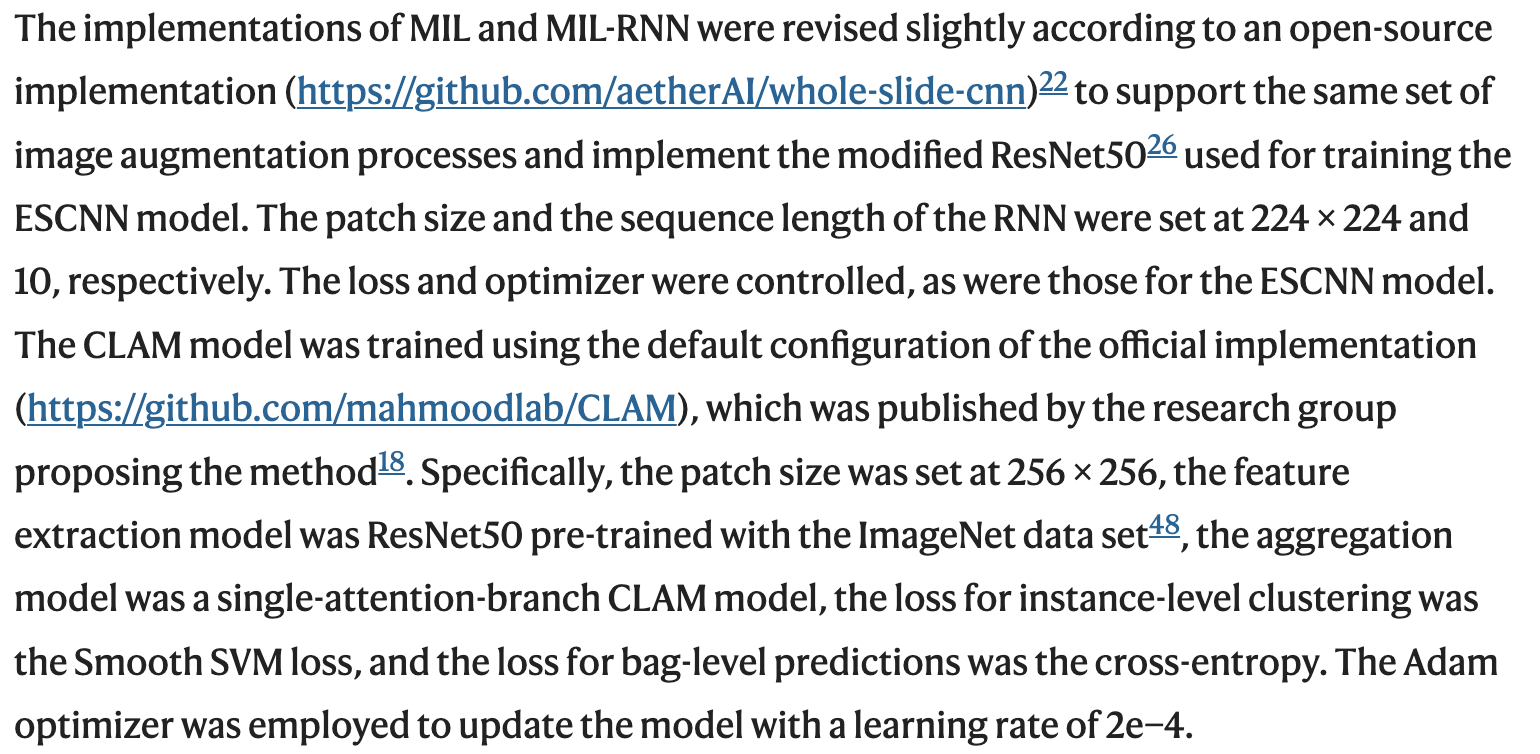

## Dataloader

In [39]:
import os

json_path_train = "./dataset/json/train_mil_bag.json"
json_path_val = "./dataset/json/val_mil_bag.json"

checkpoint_path = "../result/checkpoint"
xlsx_path = "../result/xlsx"
# seed_everything(fix_value["seed"])

# init logger
tensorboard_path = "../result/tensorboard"
writer = SummaryWriter(log_dir=tensorboard_path, flush_secs=10)
train_recoder = Recoder(xlsx_path, "train")
val_recoder = Recoder(xlsx_path, "val")
# test_recoder = Recoder(xlsx_path, "test")

# init dataloader
train_loader, val_loader = init_dataloader_(
    train_imgs_dir_path, json_path_train, json_path_val, df_train_clinical_data
)

load data from ./dataset/json/train_mil_bag.json


Preloading bag data:   0%|                                                                     | 0/3041 [00:00…

load data from ./dataset/json/val_mil_bag.json


Preloading bag data:   0%|                                                                     | 0/1014 [00:00…

# MILNet 모델 생성

In [40]:
import numpy as np
import torch
from models.attention_aggregator import AttentionAggregator
from models.backbones.backbone_builder import BackboneBuilder
from torch import nn

# 모델 객체 생성
model = MILNetWithClinicalData(
    num_classes=fix_value["num_classes"], backbone_name=fix_value["backbone"]
)

# device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")

model = model.to(device)

# init optimizer and lr scheduler
optimizer = init_optimizer(fix_value, model)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer=optimizer, T_0=20, T_mult=2
)

# init training function
if fix_value["num_classes"] > 2:
    print(f"multiple classification")
    main_fun = train_val_test_multi_class
else:
    print(f"binary classification")
    main_fun = train_val_test_binary_class

training with image and clinical data
classifier/Linear(325)
binary classification


In [41]:
model.parameters

<bound method Module.parameters of MILNetWithClinicalData(
  (image_feature_extractor): BackboneBuilder(
    (extractor): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=T

# Training

In [42]:
save_checkpoint

<function utils.utils.save_checkpoint(model, save_path)>

In [ ]:
# training
best_f1 = 0
best_epoch = 0
for epoch in tqdm(range(1, fix_value["epoch"] + 1)):
    scheduler.step()
    train_f1 = main_fun(
        "train",
        epoch,
        model,
        train_loader,
        optimizer,
        train_recoder,
        writer,
        fix_value["merge_method"],
    )
    val_f1 = main_fun(
        "val",
        epoch,
        model,
        val_loader,
        None,
        val_recoder,
        writer,
        fix_value["merge_method"],
    )

    # save best
    if val_f1 >= best_f1:
        best_f1 = val_f1
        best_epoch = epoch
        save_checkpoint(
            model, os.path.join(
                checkpoint_path, f"best_{fix_value['backbone']}.pth")
        )

    # save model
    if epoch % fix_value["save_epoch_interval"] == 0:
        save_checkpoint(model, os.path.join(checkpoint_path, f"{epoch}.pth"))
        save_checkpoint(model, os.path.join(checkpoint_path, f"last.pth"))

    print("-" * 120)

    # early stopping
    if train_f1 > fix_value["train_stop_f1"]:
        print(
            f"early stopping, epoch: {epoch}, train_f1: {train_f1:.3f} (>{fix_value['train_stop_f1']})"
        )
        break
        ""

    torch.cuda.empty_cache()

writer.close()
print(f"end, best_f1: {best_f1}, best_epoch: {best_epoch}")

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1, train, [2240/3041]

> Visualization of Salient Regions From Deep Learning Model\
Visualization of Salient Regions From Deep Learning Core-Needle Biopsy Model
We visualized the important regions that were more associated with metastatic status. After the processing of attention-based MIL pooling, the weights of different patches can be obtained, and the corresponding feature maps were then weighted together in the following FC layers to conduct ALN status prediction. With the attention weights, we created a heat map to visualize the important salient regions in each WSI.

> limitaition\
There are some limitations in our study. First, the selection of regions of interest within each CNB slide required pathologist guidance. Future studies will explore more advanced methods for automatic segmentation of tumor regions. Second, this is a retrospective study, and prospective validation of our model in a large multicenter cohort of EBC patients is necessary to assess the clinical applicability of the biomarker. Third, recent evidence indicated that a set of features related to tumor-infiltrating lymphocytes (TILs) was found to be associated with positive LNs in bladder cancer (22). However, due to few TILs on breast CNB slides, we only selected sufficient tumor cells for the identification of salient regions rather than whole slides. Finally, we only chose H&E stained images of CNB samples. The clinical utility of immunochemical stained images remains to be established as an interesting attempt.

# Test

In [ ]:
import json

file_path = "./dataset/json/test_mil_bag.json"
with open(file_path, "r") as outfile:
    json_path_test = json.load(outfile)

In [ ]:
len(json_path_test)

In [ ]:
import pandas as pd

test_df = pd.read_csv("./dataset/test.csv")
len(test_df)

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

test_df["암의 장경"] = test_df["암의 장경"].fillna(test_df["암의 장경"].mean())
test_df = test_df.fillna(0)


def get_values(value):
    return value.values.reshape(-1, 1)


numeric_cols = [
    "나이",
    "암의 장경",
    "ER_Allred_score",
    "PR_Allred_score",
    "KI-67_LI_percent",
    "HER2_SISH_ratio",
]
ignore_cols = ["ID", "img_path", "mask_path", "수술연월일", "N_category"]

for col in test_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = MinMaxScaler()
        # train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        # val_df[col] = scaler.transform(get_values(val_df[col]))
        test_df[col] = scaler.fit_transform(get_values(test_df[col]))
    else:
        le = LabelEncoder()
        # train_df[col] = le.fit_transform(get_values(train_df[col]))
        # val_df[col] = le.transform(get_values(val_df[col]))
        test_df[col] = le.fit_transform(get_values(test_df[col]))

In [ ]:
test_df = test_df.drop(columns=["img_path", "수술연월일"])
test_df.columns, len(test_df.columns)

In [ ]:
# Test 용 데이터세트 + 데이터로더

base_dir_test = "./dataset/test_imgs_cropped"
json_path_test = "./dataset/json/test_mil_bag.json"

test_dataset = BreastDataset(
    with_label=False,
    json_path=json_path_test,
    data_dir_path=test_imgs_dir_path,
    clinical_data_path=test_df,
    is_preloading=True,
    transform=transform_test,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=0
)

# Inference

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    patient_name_list = []
    threshold = 0.5
    if device.type == "mps":
        with torch.no_grad():
            for i, item in tqdm(enumerate(test_loader)):
                patient_name = item["patient_id"][0]
                bag_tensor = item["bag_tensor"].to(torch.float32).to(device)
                clinical_data = (
                    item["clinical_data"][0].to(torch.float32).to(device)
                    if "clinical_data" in item
                    else None
                )

                output, attention_value = model(bag_tensor, clinical_data)

                score = F.softmax(output, dim=-1).squeeze(dim=0)[1].cpu().item()

                preds.append(score)
                patient_name_list.append(patient_name)

        # preds = np.where(np.array(preds) > threshold, 1, 0)
    else:  # cuda
        with torch.no_grad():
            for i, item in tqdm(enumerate(test_loader)):
                patient_name = item["patient_id"][0]
                bag_tensor = item["bag_tensor"].cuda()
                clinical_data = (
                    item["clinical_data"][0].cuda() if "clinical_data" in item else None
                )

                output, attention_value = model(bag_tensor, clinical_data)

                score = F.softmax(output, dim=-1).squeeze(dim=0)[1].cpu().item()

                preds.append(score)
                patient_name_list.append(patient_name)

    d = {"name": patient_name_list, "preds": preds}
    df = pd.DataFrame(data=d)

    return df

### Test 용 모델 로드

In [ ]:
backbone = fix_value["backbone"]
model_name = f"best_{backbone}.pth"

model = MILNetWithClinicalData(
    num_classes=fix_value["num_classes"], backbone_name=fix_value["backbone"]
)

# device : mps의 경우 index=0 옵션 때야함
if device.type == 'mps':
    device = torch.device('mps') 
model.load_state_dict(
    torch.load(f"../result/checkpoint/{model_name}", map_location=device)
)


In [ ]:
# 최종 inference 결과 추출
df_result = inference(model, test_loader, device)
df_result.head()

In [ ]:
# 최종 test 예측 집계

threshold = 0.5  # 임계치

df_pv = df_result.pivot_table(index="name", values="preds", aggfunc="mean")
df_pv.preds = df_pv.preds.apply(lambda x: 1 if x >= threshold else 0)
df_pv = df_pv.reset_index()
df_pv = df_pv.rename(columns={"name": "ID", "preds": "N_category"})
display(df_pv.head(20))
df_pv.N_category.value_counts()

### Submission

In [ ]:
# submit['N_category'] = preds
from datetime import datetime

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

optimizer = fix_value["optimizer"]
df_pv.to_csv(
    f"../result/inference/submit_min_density_{min_density}_임계치_{threshold}_{backbone}&{optimizer}_{current_time}.csv",
    index=False,
)